In [1]:
import numpy as np
import xarray as xr

# --------------------------------------------------
# USER PARAMETERS
# --------------------------------------------------
VEL_EPS = 1e-3      # threshold for "stagnation"
TRACE_EPS = 1e-6    # near-zero divergence for centre
# --------------------------------------------------

def pole_correct_UV(dax, day, x="longitude", y="latitude"):
    """
    Correct U and V data so that it will plot nicely at the pole

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name

    Returns
    -------
    bu,bv : corrected U and V components
    """

    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    return bu,bv,lon2d,lat2d

def compute_gradients(u, v, dx, dy):
    """Compute spatial derivatives using central differences."""
    du_dx = np.gradient(u, dx, axis=-1)
    du_dy = np.gradient(u, dy, axis=-2)
    dv_dx = np.gradient(v, dx, axis=-1)
    dv_dy = np.gradient(v, dy, axis=-2)
    return du_dx, du_dy, dv_dx, dv_dy


def classify_flow(u, v, dx, dy):
    """
    Classify flow structures using eigenvalues of velocity gradient tensor.
    Returns masks for saddles and centres.
    """

    du_dx, du_dy, dv_dx, dv_dy = compute_gradients(u, v, dx, dy)

    # Tensor invariants
    trace = du_dx + dv_dy
    det = du_dx * dv_dy - du_dy * dv_dx

    # Discriminant of characteristic equation
    disc = trace**2 - 4 * det

    # Velocity magnitude
    speed = np.sqrt(u**2 + v**2)
    stagnation = speed < VEL_EPS

    # ----------------------------
    # Classification
    # ----------------------------

    # Saddle: real eigenvalues, opposite sign
    saddle = (det < 0) & stagnation

    # Centre: imaginary eigenvalues (rotation dominated)
    centre = (det > 0) & (disc < 0) & (np.abs(trace) < TRACE_EPS) & stagnation

    return {
        "saddle": saddle,
        "centre": centre,
        "trace": trace,
        "determinant": det,
        "discriminant": disc,
        "speed": speed,
    }


# --------------------------------------------------
# EXAMPLE: Load data from NetCDF
# --------------------------------------------------
ds = xr.open_dataset("cmems_mod_arc_phy_my_topaz4_P1M_vxo-vyo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")

year = "1994"

u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

u,v,x,y = pole_correct_UV(u,v)


dx = np.mean(np.diff(x))
dy = np.mean(np.diff(y))

results = classify_flow(u, v, dx, dy)

# Add to dataset
ds["saddle_mask"] = (("y", "x"), results["saddle"])
ds["centre_mask"] = (("y", "x"), results["centre"])
ds["trace"] = (("y", "x"), results["trace"])
ds["determinant"] = (("y", "x"), results["determinant"])

ds.to_netcdf("flow_classification.nc")


/noc/users/thopri/miniforge3/envs/AISIT/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1305: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/noc/users/thopri/miniforge3/envs/AISIT/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1334: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
/tmp/ipykernel_1499005/600878690.py:63: RuntimeWarning: invalid value encountered in multiply
  det = du_dx * dv_dy - du_dy * dv_dx
/tmp/ipykernel_1499005/600878690.py:63: RuntimeWarning: invalid value encountered in subtract
  det = du_dx * dv_dy - du_dy * dv_dx
/tmp/ipykernel_1499005/600878690.py:66: RuntimeWarning: invalid value encountered in subtract
  disc = trace**2 - 4 * det


In [2]:
def add_streamline_plot_to_ax(dax, day, axs, x="longitude", y="latitude", **figkwargs):
    """
    Add a streamlines plot to a pre-existing set of axes

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    axs : matplotlib.axes.Axes
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name
    **figkwargs : optional
        An assortment of figkwargs. See the matplotlib.pyplot.streamplot documentation for details

    Returns
    -------
    p : matplotlib.pyplot.streamplot
    """



    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    lw = 25 * np.sqrt(bu**2 + bv**2)# / np.sqrt(bu**2 + bv**2).max()
    lw = np.nan_to_num(lw, nan=0.0)

    figkwargs = {
        "density": 4,
        "linewidth": lw,
        "arrowsize": 1,
        "color": magnitude,
        "cmap":'viridis',
        **figkwargs,
    }

    p = axs.streamplot(lon2d, lat2d, bu, bv, transform=ccrs.PlateCarree(), **figkwargs)

    cbar = plt.colorbar(p.lines, ax=ax, pad=0.05)
    cbar.set_label("Speed (m/s)")

    plt.title(f"Velocity Streamlines for year {year}")

    return p

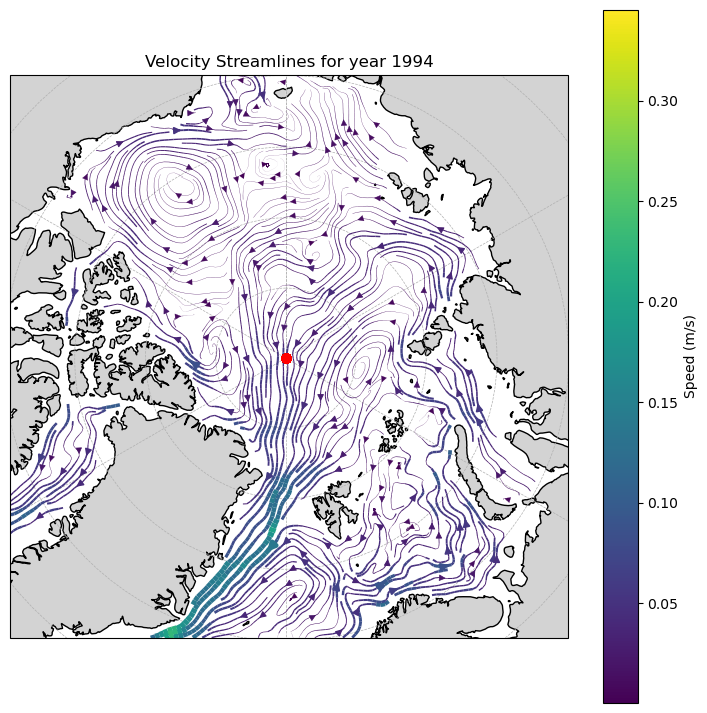

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # because u/v are on lat-lon grid

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj_map)
#
# # Focus on Arctic (change for Antarctic)
ax.set_extent([-180, 180, 70, 90], crs=proj_data)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')
u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

ax = add_streamline_plot_to_ax(u,v,ax)

# -------------------------------
# Plot saddle points
# -------------------------------
plt.scatter(x[results['saddle']], y[results['saddle']], c='red', s=40, label='Saddles', zorder=5)
plt.show()